Example of script to make a violin plot of number of UMI per spot.<br>

Input files are downsampled.<br>

data files needed to run are available at SCP: https://singlecell.broadinstitute.org/single_cell/study/SCP979/<br>
please download:<br>
10015CN108_C2_downsamp.tsv <br>
10015CN108_D2_downsamp.tsv <br>
10015CN108_E1_downsamp.tsv <br>
10015CN108fl_D1_downsamp.tsv <br>
10015CN108fl_D2_downsamp.tsv <br>
10015CN108fl_E2_downsamp.tsv <br>
10015CN90_C2_downsamp.tsv <br>
10015CN90_D2_downsamp.tsv <br>
10015CN90_E2_downsamp.tsv <br>
10015CN108_C2_stdata_under_tissue_IDs.txt <br>
10015CN108_D2_stdata_under_tissue_IDs.txt <br>
10015CN108_E1_stdata_under_tissue_IDs.txt <br>
10015CN108fl_D1_stdata_under_tissue_IDs.txt <br>
10015CN108fl_D2_stdata_under_tissue_IDs.txt <br>
10015CN108fl_E2_stdata_under_tissue_IDs.txt <br>
10015CN90_C2_stdata_under_tissue_IDs.txt <br>
10015CN90_D2_stdata_under_tissue_IDs.txt <br>
10015CN90_E2_stdata_under_tissue_IDs.txt <br>

In [1]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import matplotlib.patches as mpatches
import matplotlib
from matplotlib.text import Text
from matplotlib import transforms, lines
import matplotlib.transforms as mtransforms
from matplotlib.font_manager import FontProperties
from seaborn.utils import remove_na
from scipy import stats
from mlxtend.evaluate import permutation_test
DEFAULT = object()
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def condition(row):
    """ Takes row in pandas df as input and returns type of condition
    
    """
    # The samples are run in triplicate based on condition
    condition = ['HE', 'DAPI', 'Nestin']

    if row['index'] in ['10015CN108fl_D1', '10015CN108fl_D2', '10015CN108fl_E2']: 
        return condition[2]
        
    elif row['index'] in ['10015CN90_C2', '10015CN90_D2', '10015CN90_E2']:
        return condition[1]
    
    elif row['index'] in ['10015CN108_C2', '10015CN108_D2', '10015CN108_E1']:
        return condition[0]
        

In [16]:
# Load input files, tsv files from st-pipeline

path = '../../smomics_data'

files_dict = {}
tmp = list()

filez = ['10015CN108fl_D2_downsamp.tsv',
         '10015CN108fl_E2_downsamp.tsv',
         '10015CN108fl_D1_downsamp.tsv',
         '10015CN90_C2_downsamp.tsv',
         '10015CN90_D2_downsamp.tsv',
         '10015CN90_E2_downsamp.tsv',
        '10015CN108_C2_downsamp.tsv',
         '10015CN108_D2_downsamp.tsv',
         '10015CN108_E1_downsamp.tsv'] 

# First is to get all the names in order
for z in filez:
    filename = os.path.join(path, z)
    tmp.append(filename)
tmp.sort()
    
for filename in tmp:
    
    # Store file name
    name = '_'.join([filename.split('/')[-1].split('_')[0], filename.split('/')[-1].split('_')[1]])
    
    file = pd.read_csv(filename, sep = '\t', index_col=0)

    files_dict[name] = file.T
    


In [18]:
# I only want to look at spots under tissue so I pick the spots from the *stdata_under_tissue_IDs.txt files

samples_list = ['10015CN108fl_D1', '10015CN108fl_D2', '10015CN108fl_E2',
               '10015CN90_C2', '10015CN90_D2', '10015CN90_E2',
               '10015CN108_C2', '10015CN108_D2', '10015CN108_E1']

# SPots under tissue
path_spots = '../../smomics_data'

genes_under_tissue_dict = {}
tmp = list()

# First is to get all the names in order
for filename in glob.glob(os.path.join(path_spots, '*_IDs.txt')):
    tmp.append(filename)
tmp.sort()
    
for filename in tmp:
    
    # Store file name
    # Example name: 10015CN84_D1_stdata_under_tissue_IDs.txt
    name = '_'.join([filename.split('/')[-1].split('_')[0], filename.split('/')[-1].split('_')[1]])
        
    #print(name)
    
    file = pd.read_csv(filename, sep = '\t', index_col=0)
    
    spot_coord = list()
    
    # if spot coordinates in float...
    if len(list(file)[0].split('.')) == 3:
        for spots in list(file):
            spot_tmp = [ float(elem) for elem in spots.split('_') ]
            spot_tmp2 = [ round(elem, 0) for elem in spot_tmp ]
            spot_tmp3 = [ int(elem) for elem in spot_tmp2 ]

            new_spot_coord = str(spot_tmp3[0]) + 'x' + str(spot_tmp3[1])
            spot_coord.append(new_spot_coord)
    else:
        for spots in list(file):
            spots_tmp = spots.split('_')
            new_spot_coord = str(spots_tmp[0]) + 'x' + str(spots_tmp[1])   
            spot_coord.append(new_spot_coord)
        
    # Only store those samples I am interested in
    if name in samples_list:
        genes_under_tissue_dict[name] = spot_coord
        print(name, len(spot_coord))


10015CN108_C2 611
10015CN108_D2 672
10015CN108_E1 602
10015CN108fl_D2 539
10015CN108fl_E2 562
10015CN90_C2 737
10015CN90_D2 705
10015CN90_E2 691


In [20]:
# Since I didn't have the *stdata_under_tissue.txt file for 10015CN108fl_D1 I had to use the annotation file:

D1annot = '../../smomics_data/10015CN108fl_D1_annotations.txt'

# Store file name
D1name = '_'.join([D1annot.split('/')[-1].split('_')[0], D1annot.split('/')[-1].split('_')[1]])

file = pd.read_csv(D1annot, sep = '\t', index_col=0)

xy = []
for spots in file['x_y'].tolist():
    spot_tmp = [ float(elem) for elem in spots.split('_') ]
    spot_tmp2 = [ round(elem, 0) for elem in spot_tmp ]
    spot_tmp3 = [ int(elem) for elem in spot_tmp2 ]

    new_spot_coord = str(spot_tmp3[0]) + 'x' + str(spot_tmp3[1])
    xy.append(new_spot_coord)
print(xy[0:5])

genes_under_tissue_dict[D1name] = xy


['32x24', '21x9', '24x7', '28x6', '29x20']


In [21]:
# Separate spots if they are under or outside of tissue

files_underoutside_tissue_dict = {}

for k, v in files_dict.items():
    #print(v.shape)
    
    v_under_tissue = v[genes_under_tissue_dict[k]]
    
    # Spots outside of tissue
    spots_outside_tissue = [x for x in list(v) if x not in list(v_under_tissue)]
    print(len(spots_outside_tissue))
    v
    v_outside_tissue = v[spots_outside_tissue] 
    
    #print(v_under_tissue.shape)
    #print(v_outside_tissue.shape)
    
    files_underoutside_tissue_dict[k] = [v_under_tissue, v_outside_tissue]

392
325
373
445
462
438
270
302
316


In [22]:
# Make a sample-condition dictionary
sam_cond = {'Nestin': ['10015CN108fl_D1', '10015CN108fl_D2', '10015CN108fl_E2'], #'10015CN108fl_D1'
           'DAPI':['10015CN90_C2', '10015CN90_D2', '10015CN90_E2'], 
           'HE':['10015CN108_C2', '10015CN108_D2', '10015CN108_E1']}

In [23]:
# Seq depth adjustments == cutoffs to call a gene
seq_depth = {'10015CN108fl_D1':[49494158, 49],
            '10015CN108fl_D2':[25894163, 25.9],
            '10015CN108fl_E2':[85685215, 85.7],
            '10015CN90_C2':[76553415, 76.6],
            '10015CN90_D2':[67707512, 67.7],
            '10015CN90_E2': [67041671, 67],
            '10015CN108_C2':[39322470, 39.3],
            '10015CN108_D2':[25293514, 25.3],
            '10015CN108_E1':[34784629, 34.8]}

gene_dict = {}
umi_dict = {}
values_dict = {}
all_values = []
all_values_genes = []
total_counts_dict = {}
total_genes_dict = {}
for key, value in files_underoutside_tissue_dict.items():
    print(key)
    for i, val in enumerate(value): # [inside/outside] of tissue  
    
        # Sum the counts for each gene
        val['tot count'] = val.sum(axis=1)

        # # Remove genes (rows) where the total sum is less than xx
        value_red = val[val['tot count'] > seq_depth[key][1]]

        # Remove tot count column
        value_red.drop(['tot count'], axis = 1, inplace=True)
            
        if i == 0: # inside tissue
            # collect summarized data
            genes_per_spot = value_red.astype(bool).sum(axis = 0).mean()
            umis_per_spot = value_red.sum(axis = 0).mean()
            gene_dict[key] = [genes_per_spot]
            umi_dict[key] = [umis_per_spot]          
            
            # collect data for norm test
            values_dict[key] = [value_red.sum(axis = 0)]
            print(umis_per_spot)
            
            # collect all umi values for plotting
            tmpvalues = pd.DataFrame(value_red.sum(axis = 0))
            tmpvalues.columns = ['value']
            tmpvalues['index'] = key
            tmpvalues['variable'] = 'UMIs inside'
            all_values.append(tmpvalues)
            
            # collect all gene values for plotting
            tmpvalues = pd.DataFrame(value_red.astype(bool).sum(axis = 0))
            tmpvalues.columns = ['value']
            tmpvalues['index'] = key
            tmpvalues['variable'] = 'Genes inside'
            all_values_genes.append(tmpvalues)
            
            # collect total counts data for plotting
            total_counts = sum(value_red.sum(axis = 1))
            total_genes = value_red.astype(bool)[value_red.astype(bool).any(axis=1)].count(axis = 0)[0]
            total_counts_dict[key] = [total_counts]
            total_genes_dict[key] = [total_genes]
            
        elif i == 1: # outside tissue
            # collect summarized data
            genes_per_spot = value_red.astype(bool).sum(axis = 0).mean()
            umis_per_spot = value_red.sum(axis = 0).mean()
            gene_dict[key].append(genes_per_spot)
            umi_dict[key].append(umis_per_spot)

            # collect data for norm test
            values_dict[key].append(value_red.sum(axis = 0))
            
            # collect all umi values for plotting
            tmpvalues = pd.DataFrame(value_red.sum(axis = 0))
            tmpvalues.columns = ['value']
            tmpvalues['index'] = key
            tmpvalues['variable'] = 'UMIs outside'
            all_values.append(tmpvalues)
            
            # collect all gene values for plotting
            tmpvalues = pd.DataFrame(value_red.astype(bool).sum(axis = 0))
            tmpvalues.columns = ['value']
            tmpvalues['index'] = key
            tmpvalues['variable'] = 'Genes outside'
            all_values_genes.append(tmpvalues)
            
            # collect total counts data for plotting
            total_counts = sum(value_red.sum(axis = 1))
            total_genes = value_red.astype(bool)[value_red.astype(bool).any(axis=1)].count(axis = 0)[0]
            total_counts_dict[key].append(total_counts)
            total_genes_dict[key].append(total_genes)

# Make dataframe out of dict
df = pd.DataFrame.from_dict(gene_dict, orient='index', columns=['Genes inside', 'Genes outside']).reset_index()
df['Condition'] = df.apply(lambda row: condition(row), axis=1)
df_umi = pd.DataFrame.from_dict(umi_dict, orient='index', columns=['UMIs inside', 'UMIs outside']).reset_index()
df_umi['Condition'] = df_umi.apply(lambda row: condition(row), axis=1)
df_umi_total = pd.DataFrame.from_dict(total_counts_dict, orient='index', columns=['UMIs inside', 'UMIs outside']).reset_index()
df_umi_total['Condition'] = df.apply(lambda row: condition(row), axis=1)
df_genes_total = pd.DataFrame.from_dict(total_genes_dict, orient='index', columns=['Genes inside', 'Genes outside']).reset_index()
df_genes_total['Condition'] = df.apply(lambda row: condition(row), axis=1)

# Prepare for plotting
dfplot = pd.melt(df, id_vars=['index', 'Condition'], value_vars = ['Genes inside', 'Genes outside'])
dfplot_umi = pd.melt(df_umi, id_vars=['index', 'Condition'], value_vars = ['UMIs inside', 'UMIs outside'])
df_umi_total = pd.melt(df_umi_total, id_vars=['index', 'Condition'], value_vars = ['UMIs inside', 'UMIs outside'])
df_genes_total = pd.melt(df_genes_total, id_vars=['index', 'Condition'], value_vars = ['Genes inside', 'Genes outside'])

# collect data for checking distribution 
ls = pd.DataFrame.from_dict(values_dict, orient='index', columns=['UMIs inside', 'UMIs outside']).reset_index()
ls['Condition'] = ls.apply(lambda row: condition(row), axis=1)
ls_melt = pd.melt(ls, id_vars=['index', 'Condition'], value_vars = ['UMIs inside', 'UMIs outside'])

# collect all umis per spot
all_df_umi = pd.concat(all_values)
all_df_umi['Condition'] = all_df_umi.apply(lambda row: condition(row), axis=1)

# collect all genes per spot
all_df_genes = pd.concat(all_values_genes)
all_df_genes['Condition'] = all_df_genes.apply(lambda row: condition(row), axis=1)


10015CN108_C2
5441.140752864158
10015CN108_D2
5152.5327380952385
10015CN108_E1
5715.950166112957
10015CN108fl_D1
3149.725776965265
10015CN108fl_D2
3920.801484230056
10015CN108fl_E2
9360.895017793595
10015CN90_C2
6990.81275440977
10015CN90_D2
7866.62695035461
10015CN90_E2
9513.668596237338


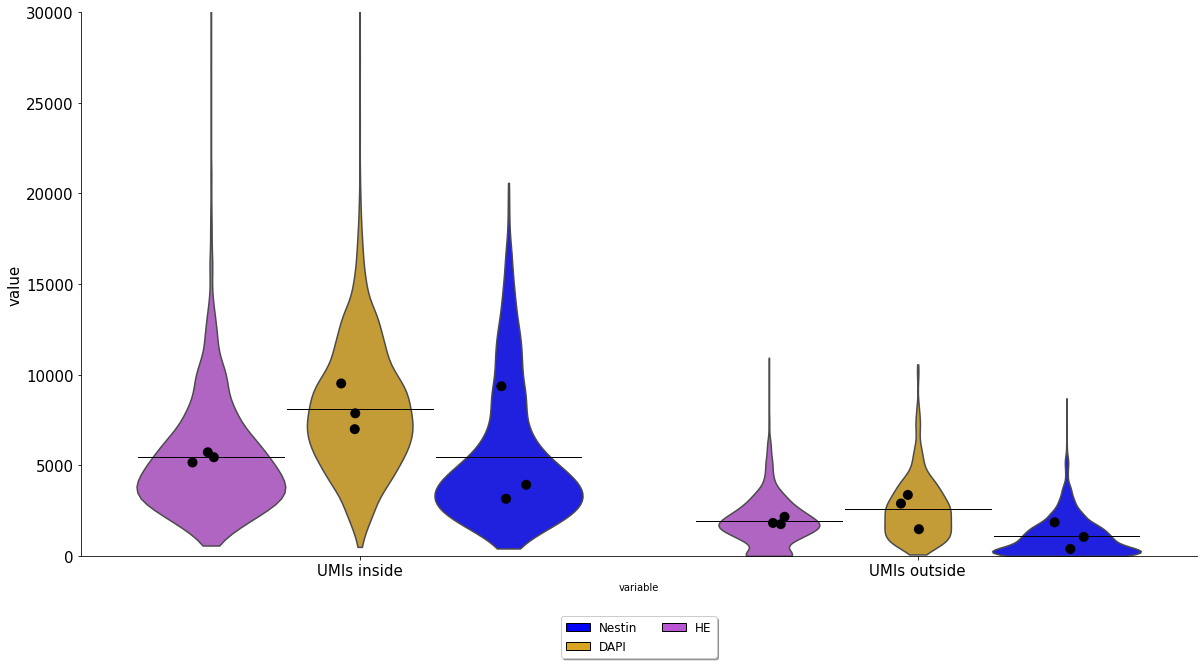

In [30]:
'Plots violin plots inside vs. outside tissue: Genes'
fig = plt.figure(figsize=(5, 5)) 

x='variable'
y='value'
hue = 'Condition'
data=dfplot_umi

ax = sns.stripplot(x=x, y=y, data=data,  hue=hue, dodge=True, hue_order=['HE', 'DAPI', 'Nestin'], order = ['UMIs inside', 'UMIs outside'], palette = [ 'black','black',],size=10)

# change background color and figure borders
back_c = 'white'
ax.set_facecolor(back_c)
ax.grid(False)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('k')
ax.spines['left'].set_color('k')

# X and y label size
ax.set_xlabel("")
ax.set_ylabel("UMIs per spot (mean)", fontsize=15)
ax.set_ylim([0,30000])

# x and y ticks
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='x', labelsize=15)

# Calculate Wilcoxons 
boxPairList = [(('UMI inside', 'HE'), ('UMI inside', 'DAPI')),
               (('UMI inside', 'HE'), ('UMI inside', 'Nestin')),
               (('UMI inside', 'DAPI'), ('UMI inside', 'Nestin')),
               (('UMI outside', 'HE'), ('UMI outside', 'DAPI')),
              (('UMI outside', 'HE'), ('UMI outside', 'Nestin')),
              (('UMI outside', 'Nestin'), ('UMI outside', 'DAPI'))]

sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 1},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            x=x,
            y=y,
            data=data,
            hue=hue,
            hue_order=['HE', 'DAPI', 'Nestin'], 
            order = ['UMIs inside', 'UMIs outside'],
            showfliers=False,
            showbox=False,
            showcaps=False,
            ax=ax)

sns.violinplot(x=x, 
                    y=y, 
                    data=all_df_umi, 
                    hue=hue, 
                    hue_order=['HE', 'DAPI', 'Nestin'], 
                    order = ['UMIs inside', 'UMIs outside'], 
                    palette = ['mediumorchid', 'goldenrod', 'blue'], 
                    cut=0,
                   inner = None)

# Legend
handles, labels = ax.get_legend_handles_labels()
labels2 = ['HE', 'DAPI', 'Nestin']
handles2 = handles[0:3]

inside_patch = mpatches.Patch( facecolor='blue', label=labels2[2], edgecolor='k')
middle_patch = mpatches.Patch( facecolor='goldenrod', label=labels2[1], edgecolor='k')
outside_patch = mpatches.Patch( facecolor='mediumorchid', label=labels2[0], edgecolor='k')
ax.legend(handles = [inside_patch, middle_patch, outside_patch],loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=2, fontsize=12)


fig.set_size_inches(20, 10)
plt.savefig("../../figures/SM_ST_UMIs_stainings.pdf", transparent=True, bbox_inches = 'tight',
   pad_inches = 0, dpi=1200)